In [83]:
subj = "Subj1"
exp = "exp_final"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = False

### Imports

In [84]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas
import matplotlib.pyplot as plt

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [85]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")

df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
df_all_features = pandas.read_feather(f"{subj}/{exp}/all_features.feather")

features = df_features.to_numpy()
print('Features: ', features.shape)
print('All features: ', df_all_features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 27)
All features:  (1046, 9875)


In [86]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    features = features[:-2]
    df_all_features = df_all_features[:-2]

### SDA

In [87]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 27 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [88]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
print(edges_true)

metrics = [ ]
for row in tqdm.tqdm(result['St_edges']):
    metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:07<00:00, 283.26it/s]


In [89]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [90]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

    return best_edges

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,20,35,20,3,Mode,"[0, 486, 682, 1046]",179676.39,35.95,3.35e-02,53.46,4.43,0.09,68.12,2.88,0.65,0.43,0.61
1,20,45,10,4,Median,"[0, 204, 556, 842, 1046]",76925.45,22.21,2.12e-02,39.07,6.12,0.06,32.48,5.39,0.68,0.49,0.61
2,40,45,10,5,Median,"[0, 204, 554, 682, 842, 1046]",168172.97,42.25,2.22e-02,54.32,4.34,0.14,69.57,2.40,0.75,0.56,0.66
3,60,35,15,6,Median,"[0, 202, 554, 682, 842, 976, 1046]",164304.01,45.33,2.40e-02,52.30,4.85,0.15,67.03,2.17,0.79,0.60,0.68
4,60,50,20,7,Median,"[0, 104, 210, 554, 682, 842, 976, 1046]",133968.57,42.61,1.33e-02,48.11,4.60,0.13,54.99,2.29,0.78,0.58,0.65
5,0,40,10,8,Median,"[0, 91, 210, 364, 554, 682, 842, 976, 1046]",104875.66,37.46,2.05e-03,42.14,4.98,0.11,42.48,2.92,0.78,0.58,0.64
6,0,50,20,9,Median,"[0, 91, 210, 342, 553, 682, 788, 859, 977, 1046]",81112.56,35.91,4.69e-03,38.73,5.15,0.10,33.20,2.92,0.82,0.64,0.69
7,0,35,20,10,Mode,"[0, 91, 210, 342, 486, 556, 682, 787, 842, 976...",65034.89,34.59,-5.44e-03,37.03,4.47,0.09,26.81,2.95,0.84,0.68,0.72
8,40,50,20,11,Median,"[0, 91, 124, 210, 342, 486, 556, 682, 787, 842...",55924.56,32.74,-7.37e-03,34.21,4.59,0.09,22.89,3.15,0.82,0.65,0.70
9,40,45,15,12,Median,"[0, 46, 91, 124, 210, 342, 486, 556, 682, 795,...",51005.12,31.74,-2.34e-02,31.46,4.56,0.09,21.17,3.13,0.82,0.65,0.70


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,50,20,9,Median,"[0, 91, 210, 342, 553, 682, 788, 859, 977, 1046]",81112.56,35.91,4.69e-03,38.73,5.15,0.1,33.2,2.92,0.82,0.64,0.69


array([   0,   91,  210,  342,  553,  682,  788,  859,  977, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.07,21.97,2.89,43270.56,28.97
1,0.07,18.17,3.55,40027.89,25.29
2,0.03,11.87,5.02,25240.89,17.63
3,0.15,66.36,2.15,154678.98,43.96
4,0.19,71.85,1.72,181286.33,55.82
5,0.07,12.41,3.54,29805.68,26.48
6,0.11,30.52,2.28,82370.57,43.11
7,0.12,32.44,2.18,92219.59,46.02


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 88.3)","(89.1, 198.7)","(199.5, 319.5)","(320.3, 505.9)","(506.7, 620.3)","(621.1, 710.7)","(711.5, 773.1)","(773.9, 877.9)","(878.7, 938.7)"
"Time length, sec",78.4,109.6,120.0,185.6,113.6,89.6,61.6,104.0,60.0
Number of epochs,91,119,132,211,129,106,71,118,69


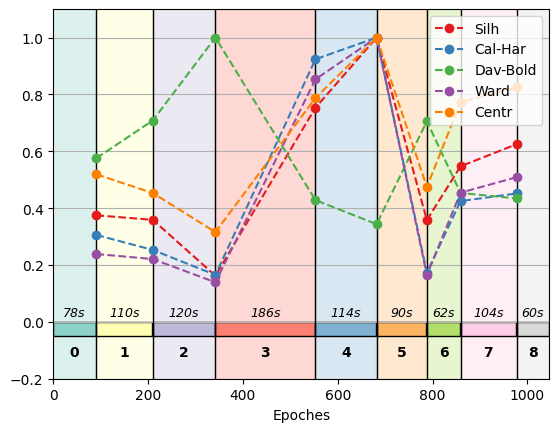

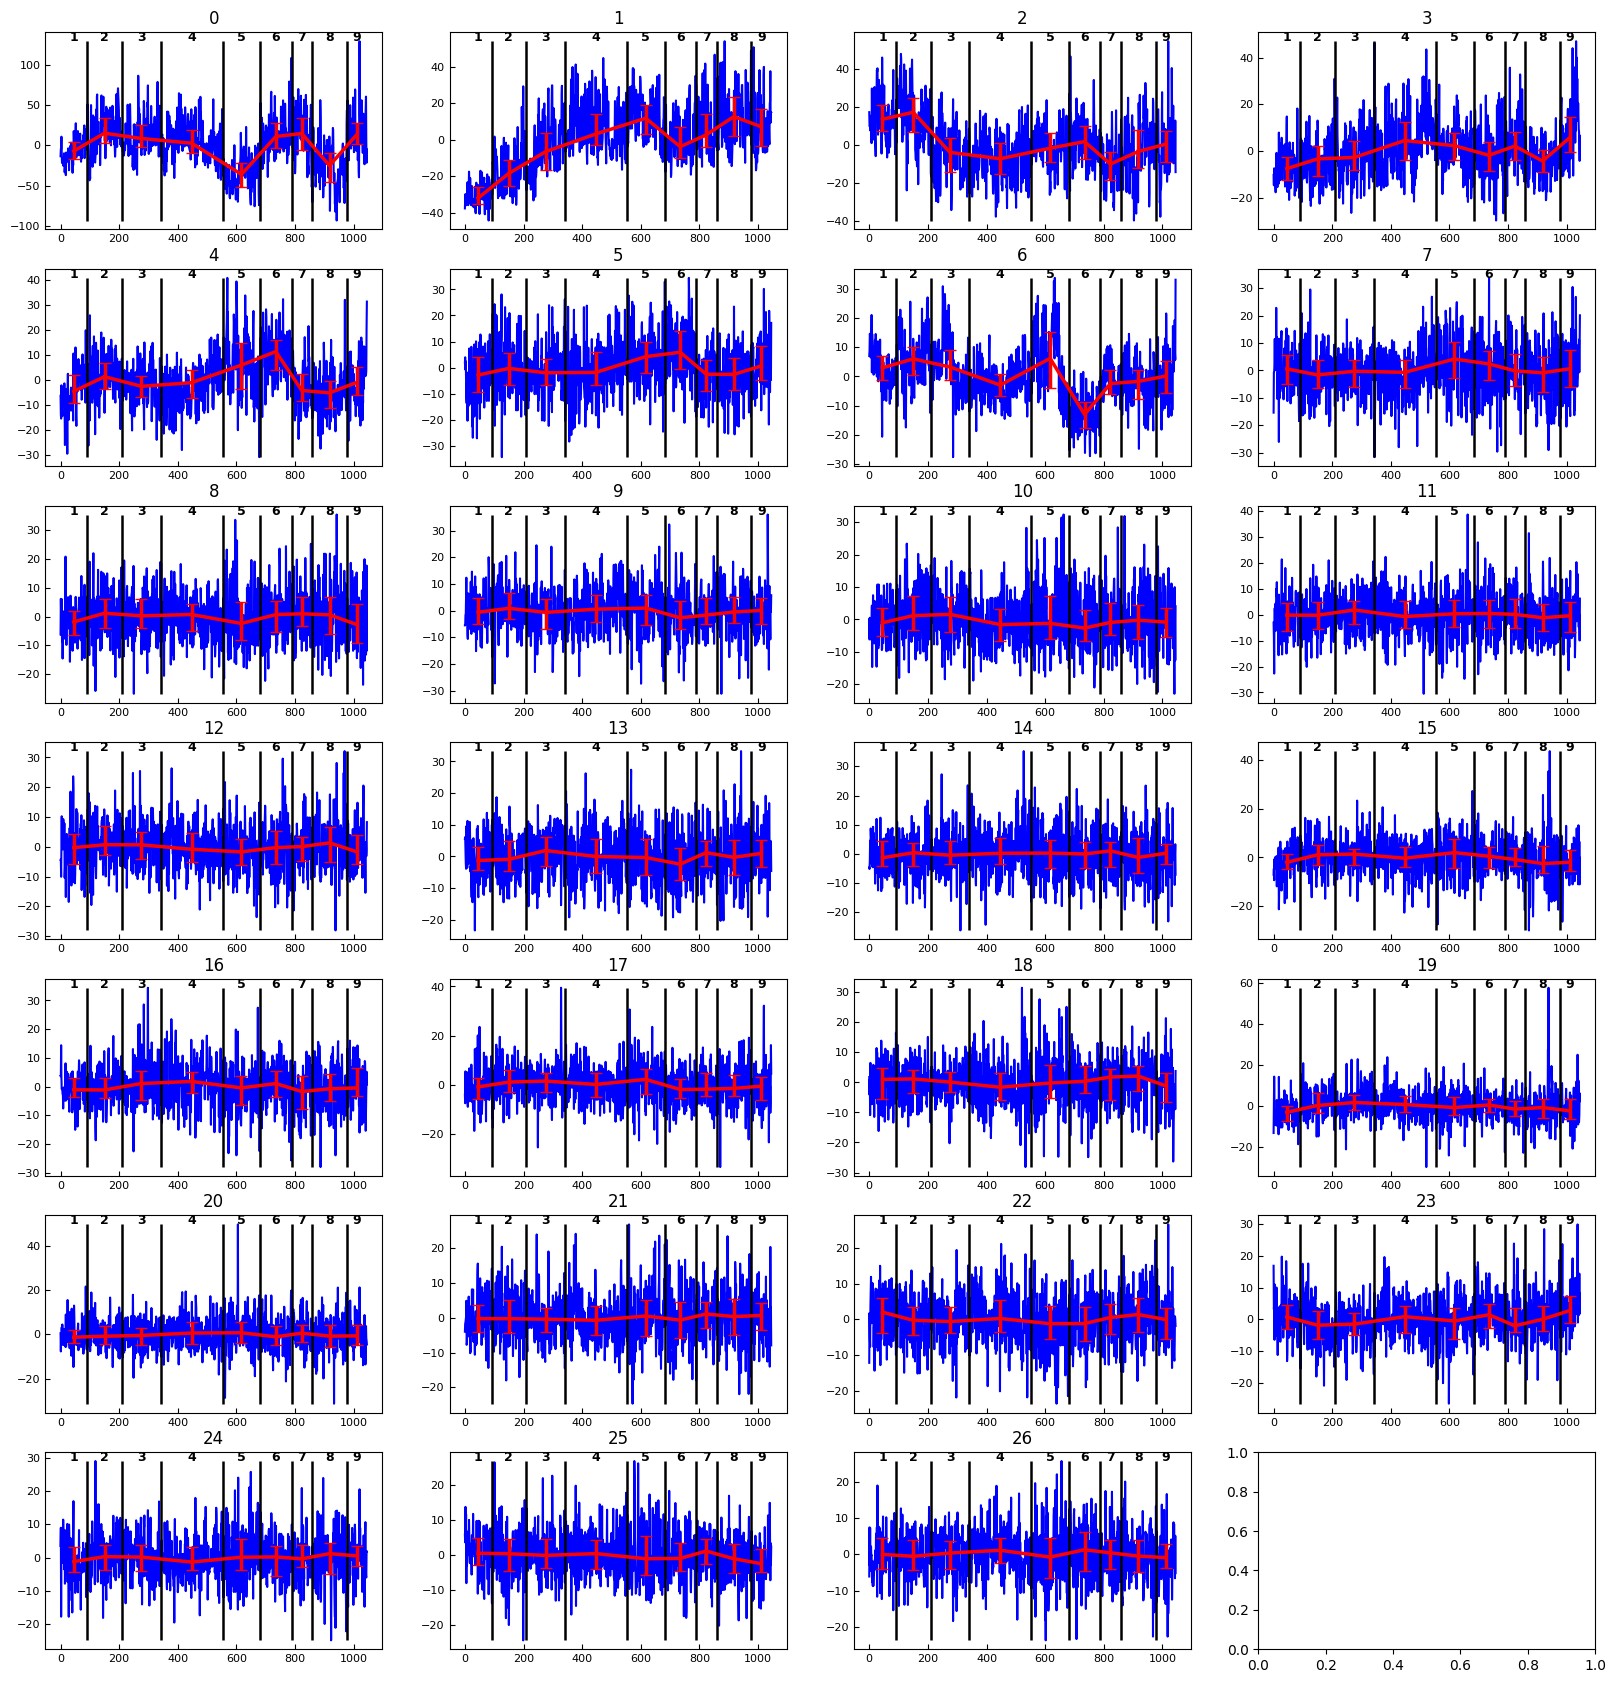

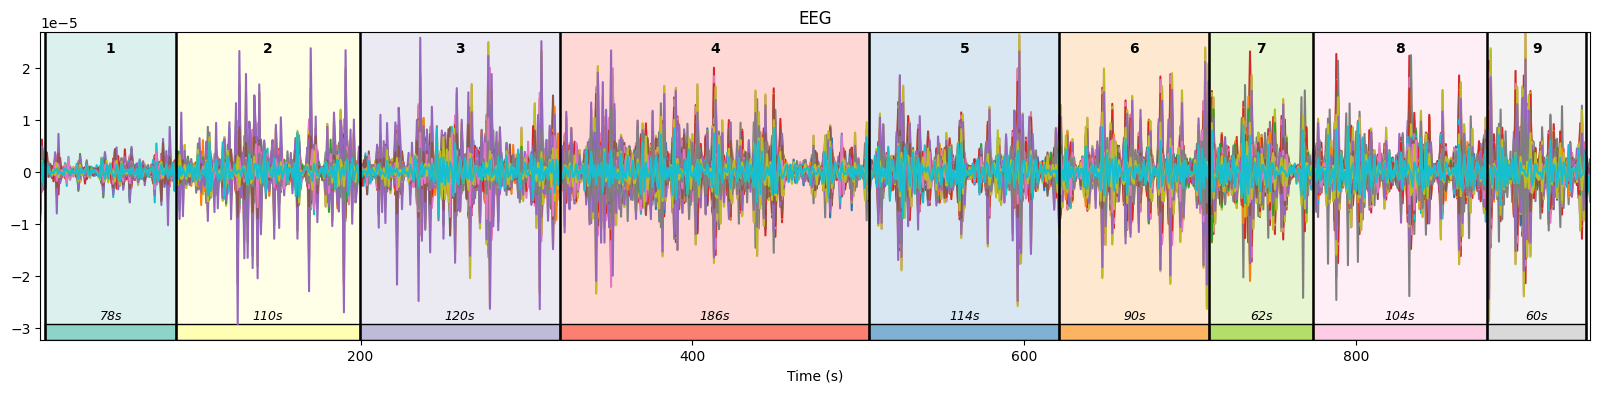

In [91]:
internal_edges = analyze(result, 'Avg-Silh', "internal")
# 0.88	0.8	0.83 - var_limit = 0.005

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,20,35,20,3,Mode,"[0, 486, 682, 1046]",179676.39,35.95,3.35e-02,53.46,4.43,0.09,68.12,2.88,0.65,0.43,0.61
1,20,40,15,4,Median,"[0, 204, 558, 859, 1046]",76066.77,22.01,2.12e-02,38.75,6.15,0.06,32.13,5.44,0.70,0.49,0.61
2,60,35,20,5,Median,"[0, 204, 554, 682, 859, 1046]",163253.92,41.14,2.26e-02,53.12,4.65,0.13,67.36,2.49,0.76,0.57,0.66
3,0,50,10,6,Mode,"[0, 91, 248, 554, 682, 842, 1046]",128760.72,38.06,6.05e-03,47.56,4.32,0.11,53.03,2.66,0.77,0.62,0.69
4,0,50,10,7,Mean,"[0, 94, 250, 528, 682, 834, 977, 1046]",118737.43,38.39,6.24e-03,44.12,5.09,0.11,47.68,2.60,0.80,0.67,0.72
5,60,35,20,8,Mean,"[0, 94, 229, 483, 555, 682, 838, 977, 1046]",91158.55,36.42,-6.11e-03,41.51,4.61,0.10,36.57,2.74,0.82,0.69,0.73
6,20,50,20,9,Mode,"[0, 91, 248, 342, 486, 554, 682, 842, 976, 1046]",78441.18,33.72,-1.03e-02,38.67,4.72,0.09,31.49,3.13,0.83,0.69,0.73
7,20,50,20,10,Mode,"[0, 91, 248, 342, 486, 554, 682, 787, 842, 976...",62586.12,33.80,-8.20e-03,36.45,4.60,0.09,25.60,3.08,0.85,0.72,0.76
8,20,50,20,11,Mode,"[0, 46, 91, 248, 342, 486, 554, 682, 787, 842,...",55185.44,32.27,-2.44e-02,33.56,4.53,0.08,22.77,3.14,0.86,0.73,0.77
9,20,50,10,12,Mode,"[0, 46, 91, 248, 342, 486, 554, 682, 708, 795,...",37267.87,30.08,-2.74e-02,30.46,4.82,0.07,15.44,3.40,0.84,0.70,0.75


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,20,50,20,9,Mode,"[0, 91, 248, 342, 486, 554, 682, 842, 976, 1046]",78441.18,33.72,-0.01,38.67,4.72,0.09,31.49,3.13,0.83,0.69,0.73


array([   0,   91,  248,  342,  486,  554,  682,  842,  976, 1046])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.05,19.63,3.19,39140.90,26.07
1,0.05,14.61,3.83,32604.55,23.55
2,0.03,6.76,5.59,14132.28,15.76
3,0.05,13.58,3.54,27521.56,24.41
4,0.07,22.78,2.63,54476.56,35.02
5,0.19,88.06,1.74,223791.27,56.10
6,0.13,55.25,2.21,146965.50,44.89
7,0.11,31.23,2.28,88896.86,43.97


,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 88.3)","(89.1, 233.1)","(233.9, 319.5)","(320.3, 449.9)","(450.7, 506.7)","(507.5, 620.3)","(621.1, 758.7)","(759.5, 877.1)","(877.9, 938.7)"
"Time length, sec",78.4,144.0,85.6,129.6,56.0,112.8,137.6,117.6,60.8
Number of epochs,91,157,94,144,68,128,160,134,70


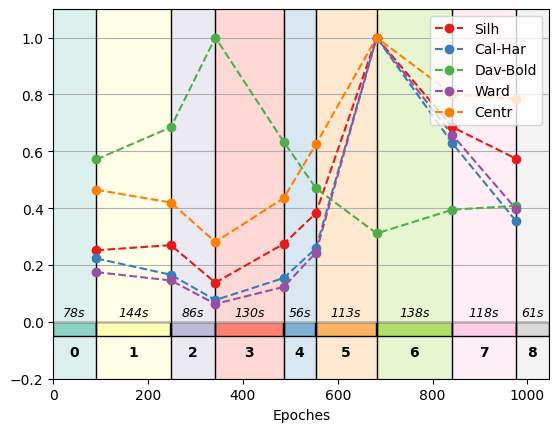

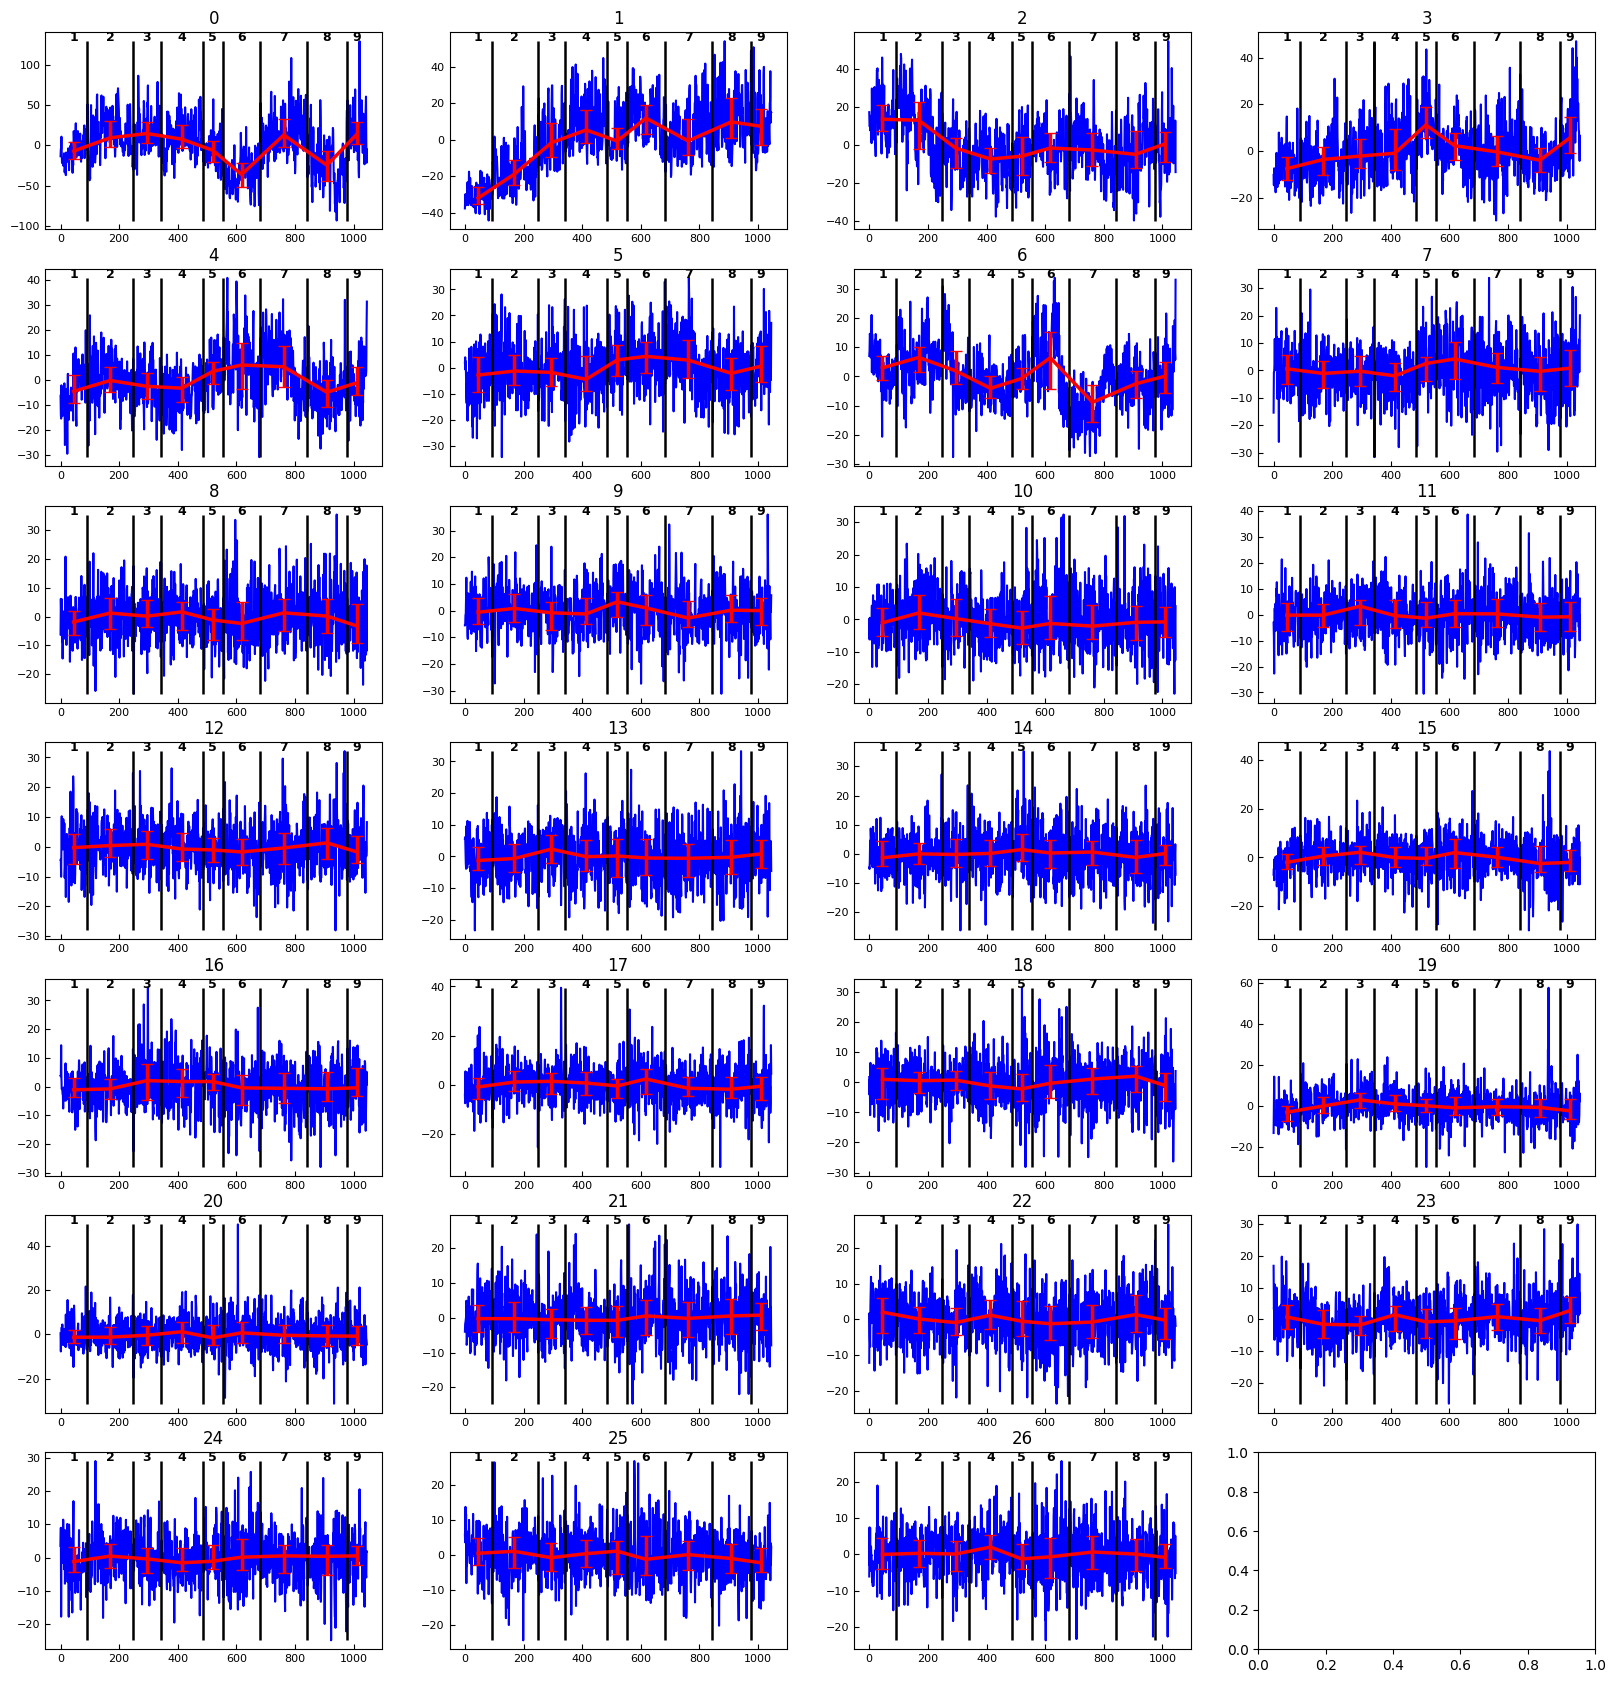

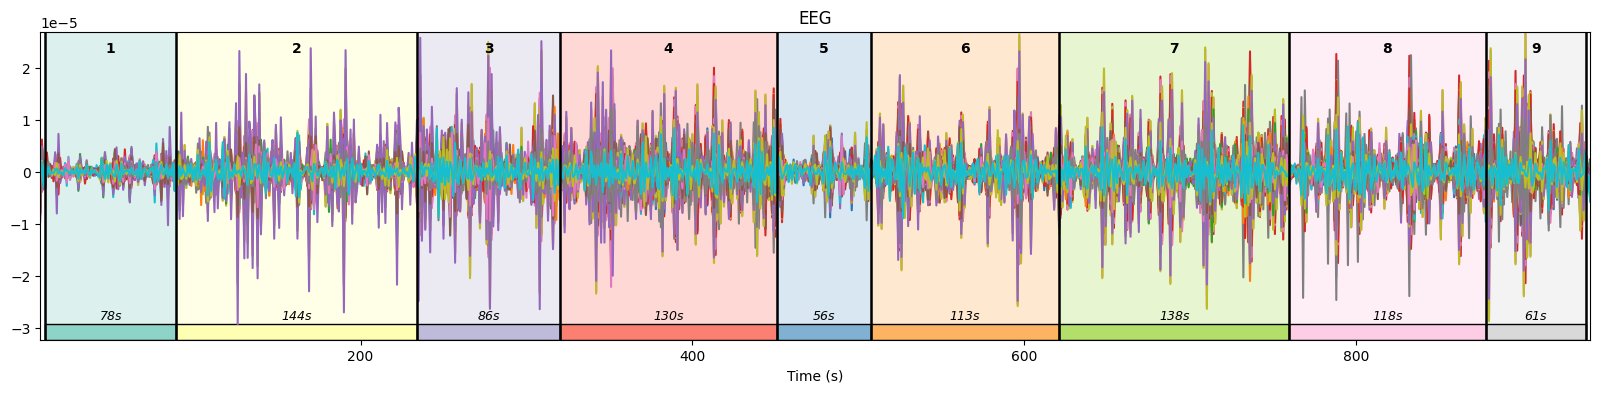

In [92]:
external_edges = analyze(result, 'FMI', "external")

### IV

In [32]:
IV = pandas.DataFrame(df_all_features.columns, columns = [ "Feature" ])
for edges, name, path in zip(
    [ edges_true, internal_edges, external_edges ],
    [ "true", "internal", "external" ],
    [ "true_iv", "internal/iv", "external/iv" ]
):
    _, labels = SDA.stageprocess.form_stage_bands(edges)
    edges_iv = SDA.analytics.IV.calc_IV_clust(df_all_features, labels)
    edges_iv.to_csv(f"{subj}/{exp}/{path}.csv")
    IV[name] = edges_iv["IV"]
IV

  9%|▊         | 849/9875 [00:27<04:53, 30.74it/s]


KeyboardInterrupt: 

In [ ]:
IV["internal-diff"] = IV["true"] - IV["internal"]
IV["external-diff"] = IV["true"] - IV["external"]
IV.to_csv(f"{subj}/{exp}/IV.csv")
IV

,Feature,true,internal,external,internal-diff,external-diff
0,feature-0 betti-1 max,0.34,0.29,0.30,5.15e-02,0.05
1,feature-0 betti-1 mean,0.00,0.00,0.00,0.00e+00,0.00
2,feature-0 betti-1 std,0.44,0.39,0.40,4.75e-02,0.04
3,feature-0 betti-1 sum,0.00,0.00,0.00,0.00e+00,0.00
4,feature-0 betti-1 norm,0.44,0.39,0.40,4.75e-02,0.04
...,...,...,...,...,...,...
9870,bd2-3 median,0.69,0.63,0.61,5.90e-02,0.08
9871,bd2-3 percentile-75,0.70,0.63,0.63,7.95e-02,0.07
9872,bd2-3 percentile-90,0.71,0.64,0.65,6.75e-02,0.06
9873,bd2-3 kurtosis,0.15,0.15,0.11,4.06e-03,0.04


<Axes: title={'center': 'External'}>

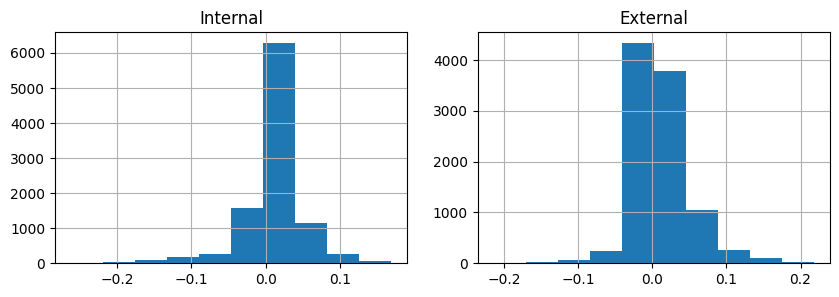

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

axes[0].set_title('Internal')
IV["internal-diff"].hist(ax = axes[0])

axes[1].set_title('External')
IV["external-diff"].hist(ax = axes[1])